[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rbg-research/AI-Training/blob/main/voice-analytics/noise_suppression/Tutorial-1.ipynb)

# Spectral Gatting in Python for Noise Reduction

* Noisereduce is a noise reduction algorithm in python that reduces noise in time-domain signals like speech, bioacoustics, and physiological signals. It relies on a method called "spectral gating" which is a form of Noise Gate.

* It works by computing a spectrogram of a signal (and optionally a noise signal) and estimating a noise threshold (or gate) for each frequency band of that signal/noise. That threshold is used to compute a mask, which gates noise below the frequency-varying threshold.

* This Algorithm requires two inputs:
    1. A noise audio clip comtaining prototypical noise of the audio clip
    2. A signal audio clip containing the signal and the noise intended to be removed

In [1]:
# Importing the necessary libraries
import IPython
from scipy.io import wavfile
import soundfile as sf
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
%matplotlib inline

# Loading Data

In [2]:
# load data
audio = "noise_sample.wav"
data, rate = sf.read(audio)
data = data 

In [3]:
# displaying the audio file 
IPython.display.Audio(data=data, rate=rate)

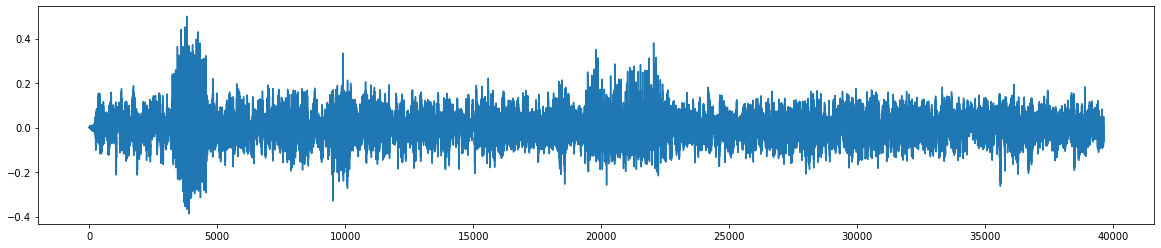

In [4]:
# plotting the audio 
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data)

In [5]:
# load data
audio = "clean_sample.wav"
data, rate = sf.read(audio)
data = data

In [6]:
# displaying the audio file 
IPython.display.Audio(data=data, rate=rate)

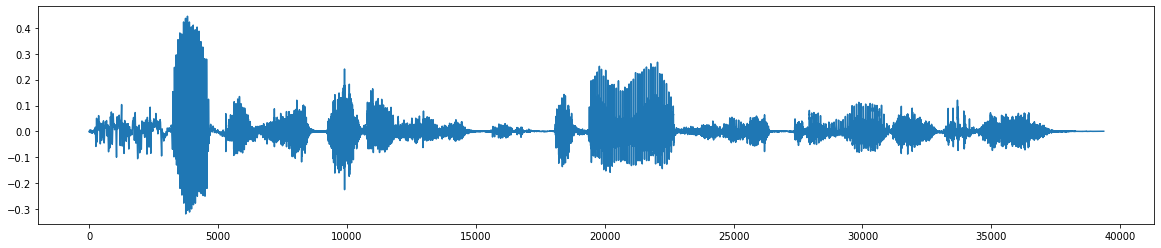

In [7]:
# plotting the audio 
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data)

# Creating an Noise Audio File

The example audio file that we have loaded is an clear audio i.e there is no background noise present in the audio. So I'm gonna add background noise to the original audio file by creating an new audio file with the help of FFT and band limited noise and will merge it together.The new audio file will contain background noise. 
Here we are defining two functions that can be called to create an audio file which will contain noise. 

In [8]:
## defining the function for fft
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real

## defining the function for band limited noise
def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

In [9]:
# calling the functions to create a noise audio
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=4000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]

# adding the created audio with the original audio
audio_clip_band_limited = data+noise

In [10]:
# displaying the new audio file 
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

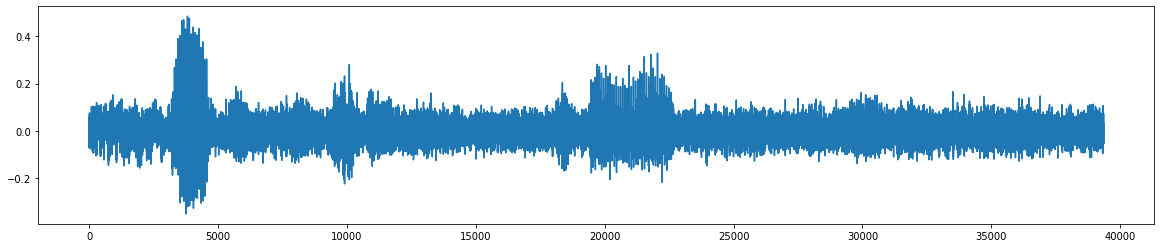

In [11]:
# plotting the audio file
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_band_limited)

# Reducing Noise

# Procedure:

1. An FFT is calculated over the noise audio clip
2. Statistics are calculated over FFT of the the noise (in frequency)
3. A threshold is calculated based upon the statistics of the noise (and the desired sensitivity of the algorithm)
4. An FFT is calculated over the signal
5. A mask is determined by comparing the signal FFT to the threshold
6. The mask is smoothed with a filter over frequency and time
7. The mask is applied to the FFT of the signal, and is inverted

In [12]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)

In [13]:
# function for plotting spectrogram
def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


In [14]:
# function for plotting the statistics calculated
def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()

In the following codes, I have defined the function followed by calculating spectrogram, statistics of noise,threshold, spectrogram for signal, mask value and smoothing filters for mask for noise reduction process. 

# Remove noise from audio based upon a clip containing only noise

 Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """

In [15]:
# functions for removing noise

def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
   
    # Steps for noise reduction
    if verbose:
        start = time.time()
    # STFT over noise 
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1) # mean
    std_freq_noise = np.std(noise_stft_db, axis=1)   # standard deviation
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh # threshold
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

STFT on noise: 0:00:00.004555
STFT on signal: 0:00:00.005922
[-57.38994303 -57.38994032 -57.38990977 ...   8.58601577   7.73725526
  11.24943354] -44.47027535178167
Masking: 0:00:00.004342
Mask convolution: 0:00:00.005948
Mask application: 0:00:00.007411
Signal recovery: 0:00:00.560804


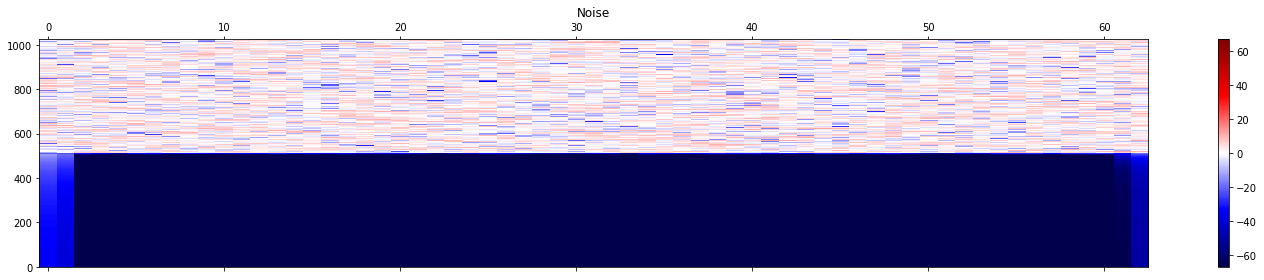

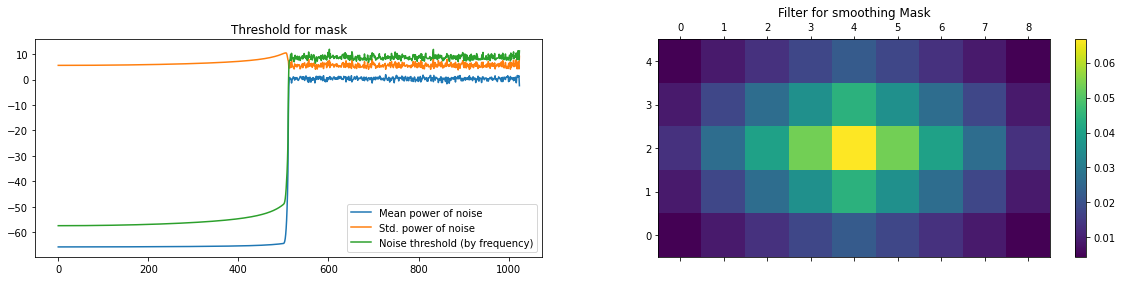

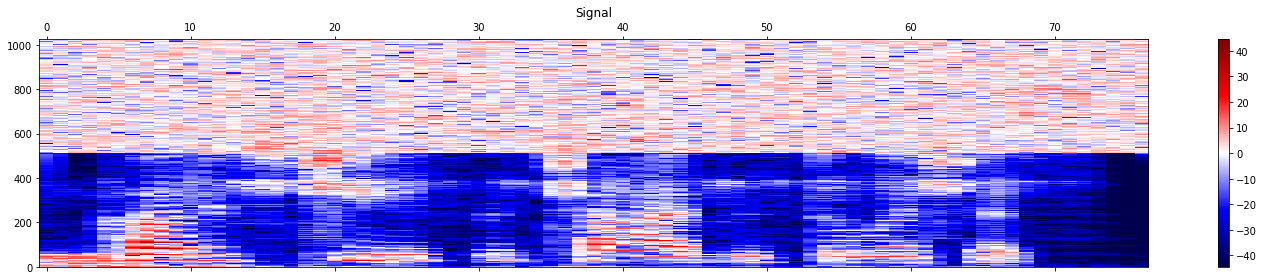

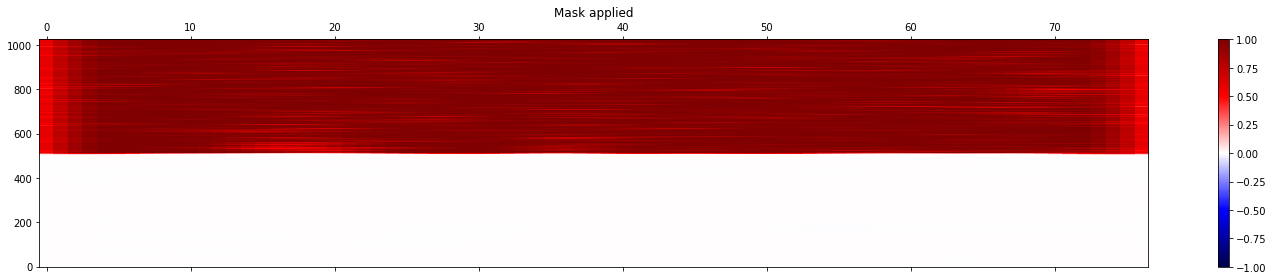

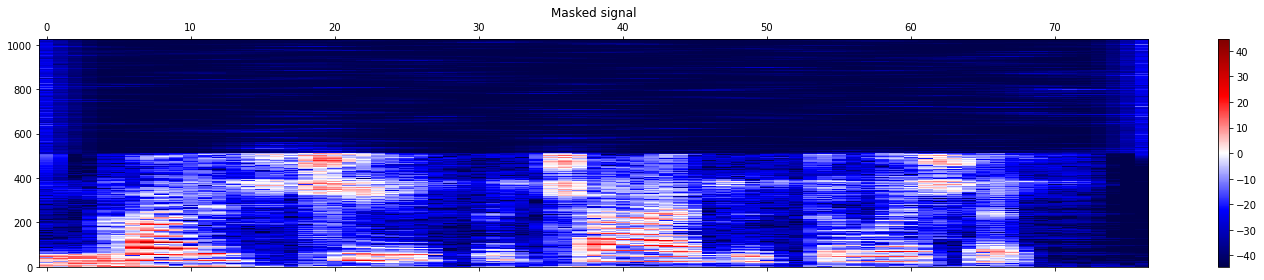

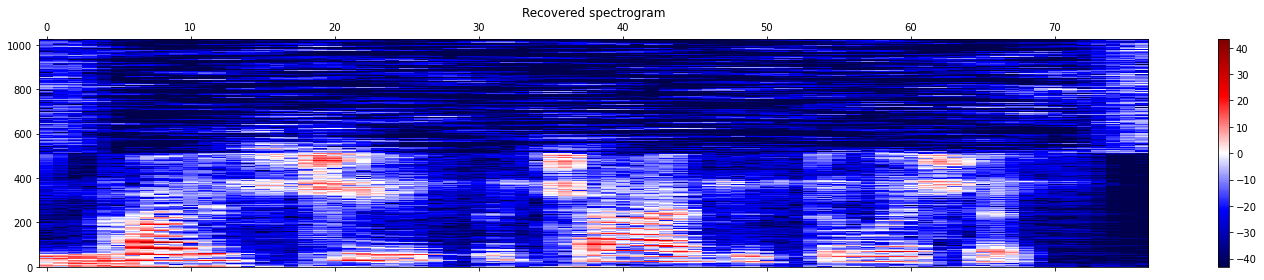

In [16]:
# passing the parameters to print result 
result = removeNoise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip,verbose=True,visual=True)

In [17]:
# Displaying the audio
IPython.display.Audio(data=result, rate=16000)

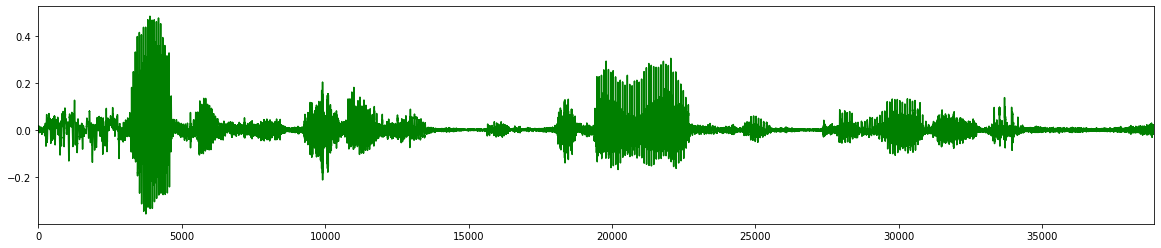

In [18]:
# plotting the reduced noise file
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(result, color='green')
ax.set_xlim((0, len(result)))
plt.show()